In [1]:
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import KFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import clear_output

import json


In [2]:
MODEL_FILE = "2.2. Esembler_DecisionTree_Bureau.json"

In [3]:
# Entscheidungsbaum
TREE_PARAMS = {
    "random_state" : 0,
    "max_depth": 7,
}

In [4]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [5]:
# Check if Models exists

In [6]:
model_path = DATASET_DIR / "Models" / MODEL_FILE
MODEL_EXIST = model_path.is_file()

In [7]:
# Daten

In [8]:
app_train = pd.read_csv(DATASET_DIR / "4. FillNA" / "application.csv")
bureau = pd.read_csv(DATASET_DIR / "4. FillNA" / "bureau.csv")
app_train = app_train.set_index("SK_ID_CURR")
bureau = bureau.set_index("SK_ID_CURR")

In [9]:
bureau.head()

,CNT_BURAEU,B_Active,B_Closed,B_CREDIT_DAY_OVERDUE,B_DAYS_CREDIT_ENDDATE,B_AMT_CREDIT_SUM,B_AMT_CREDIT_SUM_DEBT,B_AMT_CREDIT_SUM_OVERDUE,B_AMT_ANNUITY
SK_ID_CURR,,,,,,,,,
100002,8.0,2.0,6.0,0.000000,309.000000,212745.000000,81927.000000,0.000000,0.000000
100003,4.0,1.0,3.0,0.000000,1216.000000,810000.000000,0.000000,0.000000,0.000000
100004,2.0,0.0,2.0,0.000598,2294.569372,414243.226314,168078.269668,0.000210,861.827745
100007,1.0,0.0,1.0,0.000844,2323.521925,414219.927736,168159.053569,0.000282,899.320896
100008,3.0,1.0,2.0,0.000000,471.000000,267606.000000,240057.000000,0.000000,0.000000


In [10]:
# Ermittlung Reihenfolge

In [11]:
y = app_train.loc[bureau.index]["TARGET"]
x = bureau

In [12]:
if not MODEL_EXIST:
    # unterteilt den trainingsdatensatz in trainings- und validierungsdatensätze
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)

    # logistisches Regressionsmodell
    model = DecisionTreeClassifier(**TREE_PARAMS)
    model.fit(x_train, y_train)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    print(auc)

    # Koeffizienten der einzelnen Klassen
    coef_dict = {}
    for coef, feat in zip(model.feature_importances_, x.columns.values):
        coef_dict[feat] = coef

    # Feature Importance
    d = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
    order = list(d.keys())
    
    model_data = {
    "todo" : order,
    "keep" : [],
    "drop" : [],
    "params" : TREE_PARAMS,
    "auc" : [],
    "p" : [],
    "n" : []
    }
    
    auc_temp = 0.5

0.597452114891682


In [13]:
if MODEL_EXIST:
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'r') as file:
        model_data = json.load(file)
    auc_temp = model_data["auc"][-1]

In [14]:
#Entscheidungsbaum Parameterbestimmung

In [15]:
df = bureau

print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc_temp,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))
todo = model_data["todo"].copy()

for head in todo:
    
    model_data["keep"].append(head)
    
    X = df[model_data["keep"]]
    y = app_train.loc[bureau.index]["TARGET"]
    x = X
    
    model = DecisionTreeClassifier(**TREE_PARAMS).fit(x, y)
    
    aucs = []

    kfold = KFold(5, shuffle=True, random_state=1)

    for train, test in kfold.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
        aucs.append(auc)
    
    auc = np.mean(aucs)
    n = len(X)
    p = len(X.columns)
    
    if auc > auc_temp:
        
        model_data["auc"].append(auc)
        model_data["p"].append(p)
        model_data["n"].append(n)
        
        auc_temp = auc
        
    else:
        model_data["keep"].remove(head)
        model_data["drop"].append(head)
    
    model_data["todo"].remove(head)
    
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'w') as file:
        json.dump(model_data, file)
        
    clear_output(wait=True)
    print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))

auc: 0.5969, todo: 0, keep: 2, drop: 7


        auc  p       n
1  0.597431  2  263491


<AxesSubplot:>

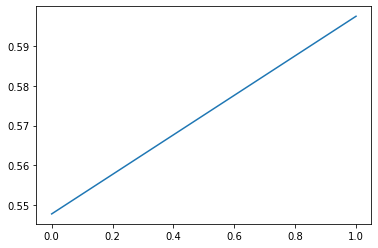

In [16]:
data = {
    "auc" : model_data["auc"],
    "p" : model_data["p"],
    "n" : model_data["n"]
}

result = pd.DataFrame(data)

print(result[result["auc"] == result["auc"].max()])
result["auc"].plot()

In [17]:
model = DecisionTreeClassifier(**TREE_PARAMS)

aucs = []

kfold = KFold(5, shuffle=True, random_state=1)

X = df[model_data["keep"]]
y = app_train.loc[bureau.index]["TARGET"]
x = X

for train, test in kfold.split(x):
    
    model.fit(x.iloc[train], y.iloc[train])
    auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
    aucs.append(auc)
    
    print('train: %s, test: %s, auc: %s' % (train, test, round(auc,4)))

print("\n")
print("Durchschnitt: %.2f" % (np.mean(aucs)))
print("Standardabw.: %.2f" % (np.std(aucs)))
print("Varianz:      %.2f" % (np.var(aucs)))

train: [     0      2      5 ... 263488 263489 263490], test: [     1      3      4 ... 263467 263476 263482], auc: 0.5919
train: [     0      1      2 ... 263488 263489 263490], test: [    21     22     24 ... 263477 263480 263484], auc: 0.6032
train: [     0      1      2 ... 263487 263488 263489], test: [     6     10     12 ... 263485 263486 263490], auc: 0.603
train: [     0      1      3 ... 263486 263487 263490], test: [     2     11     15 ... 263483 263488 263489], auc: 0.5987
train: [     1      2      3 ... 263488 263489 263490], test: [     0      5      7 ... 263472 263475 263487], auc: 0.5903


Durchschnitt: 0.60
Standardabw.: 0.01
Varianz:      0.00


In [19]:
model_data["keep"]

['B_Closed', 'B_Active']